# Proper randomization is important?

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *
import matplotlib.pyplot as plt
import pytree
print(f'pytree {pytree.__version__}')
print(f'pytree {pytree.__git_version__}')

archive_names = {
#    'order_randomization/1/grenoble_2020-11-18_1959260.zip' : 'full',
#    'order_randomization/1/grenoble_2020-11-18_1959262.zip' : 'none',
#    'order_randomization/1/grenoble_2020-11-18_1959263.zip' : 'size',
    'order_randomization/1/grenoble_2020-11-19_1959366.zip' : 'full',
    'order_randomization/1/grenoble_2020-11-19_1959367.zip' : 'none',
    'order_randomization/1/grenoble_2020-11-19_1959368.zip' : 'size',
}

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'), Loader=yaml.BaseLoader)['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name), Loader=yaml.BaseLoader)
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

def load_experiment(zip_name, exp_name=None):
    result = extract_zip(zip_name)
    # Special processing for the Pingpong dataset
    df_pingpong = result['exp/exp_PingPong.csv']
    pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
    df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration
                  ))
    result = {
        'pingpong': df_pingpong,
        'send'  : pingpong_send,
        'isend' : result['exp/exp_Isend.csv'],
        'recv'  : result['exp/exp_Recv.csv'],
        'wtime' : result['exp/exp_Wtime.csv'],
        'test'  : result['exp/exp_Test.csv'],
        'iprobe': result['exp/exp_Iprobe.csv'],
    }
    if exp_name is not None:
        for df in result.values():
            df['experiment'] = exp_name
    return result

pytree 0.1.0
pytree 132a89e9b1bc0bee4b731d40786f6bd720141c33


In [2]:
df_list = []
for archive, kind in archive_names.items():
    df = load_experiment(archive, exp_name=kind)['recv']
    df_list.append(df)
df = pandas.concat(df_list)

In [3]:
df[['msg_size', 'duration', 'experiment']].to_csv('/tmp/mpi_calibration_order.csv', index=False)

## Checking if the proper randomization gives better results

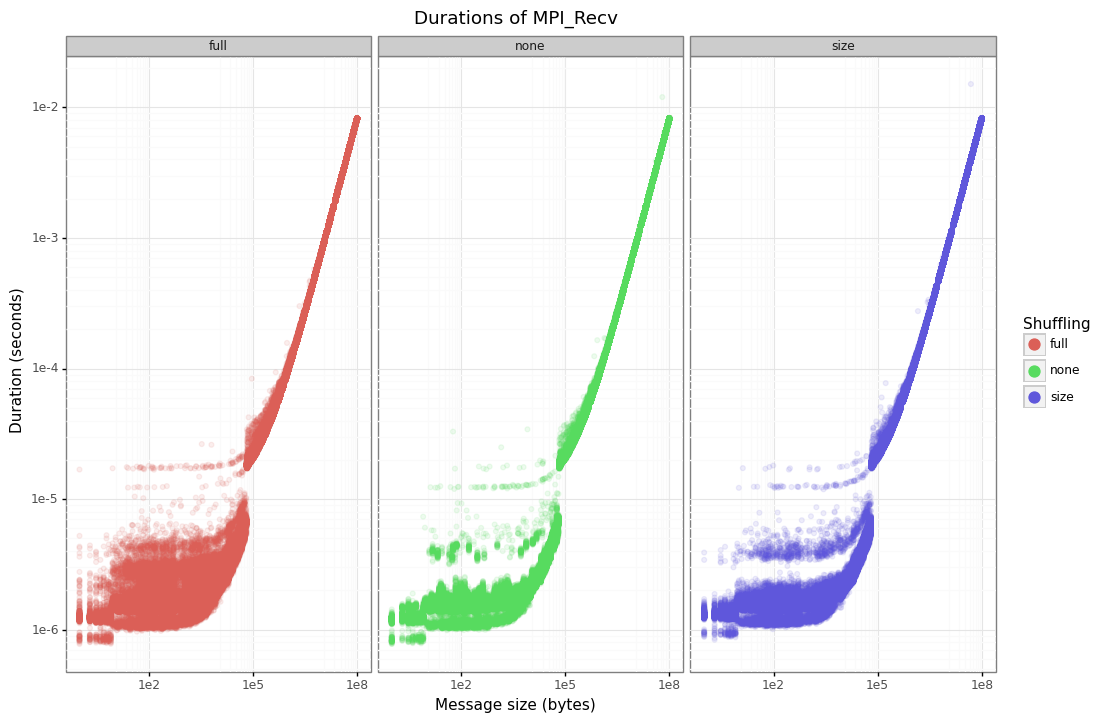

<ggplot: (8769843812577)>

In [4]:
func = df['op'].min()
(ggplot(df, aes(x='msg_size', y='duration', color='experiment'))
    + geom_point(alpha=0.1)
    + scale_x_log10()
    + scale_y_log10()
    + ggtitle(f'Durations of {func}')
    + facet_wrap('experiment')
    + theme_bw()
    + labs(x='Message size (bytes)', y='Duration (seconds)', color='Shuffling')
    + guides(color=guide_legend(override_aes={'alpha': 1, 'size': 4}))
)

In [5]:
df_aggr = df.groupby(['experiment', 'msg_size'])[['duration']].mean().reset_index()

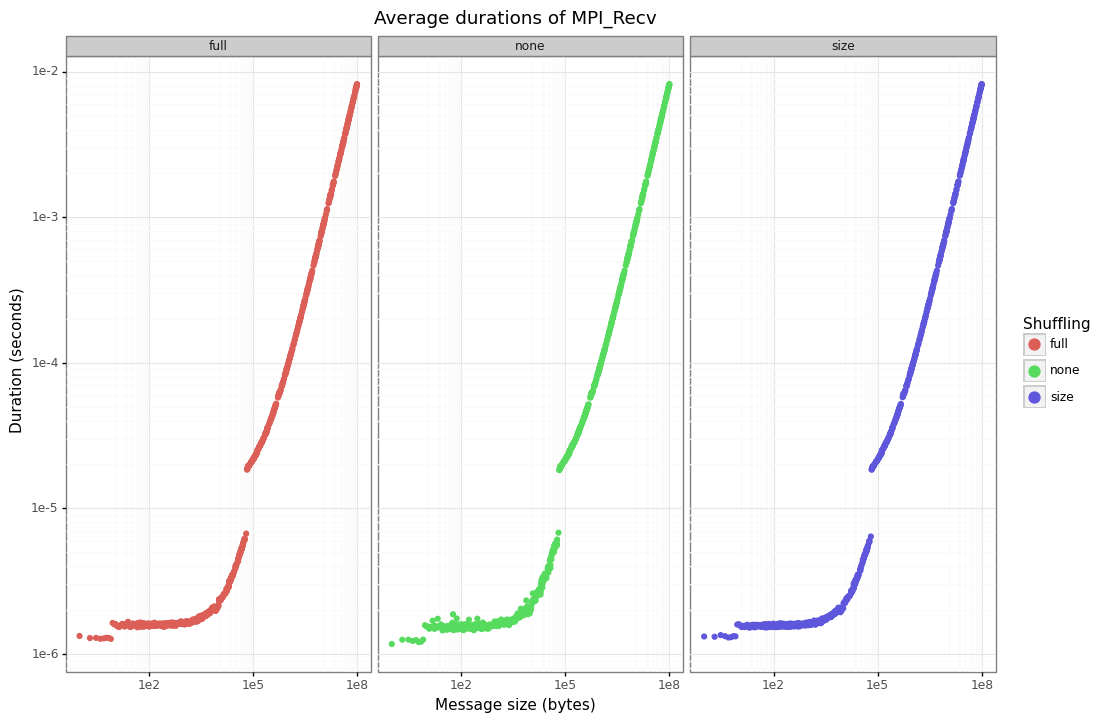

<ggplot: (-9223363267026247543)>

In [6]:
func = df['op'].min()
(ggplot(df_aggr, aes(x='msg_size', y='duration', color='experiment'))
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
    + ggtitle(f'Average durations of {func}')
    + facet_wrap('experiment')
    + theme_bw()
    + labs(x='Message size (bytes)', y='Duration (seconds)', color='Shuffling')
    + guides(color=guide_legend(override_aes={'alpha': 1, 'size': 4}))
)